# Implement the Decision Tree Algorithm

## Import the libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

## Main Class

In [23]:
class DecisionTree(object):
    def __init__(self, split_loss_function, leaf_value_estimator, depth=0, min_sample=5, max_depth=10):
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.min_sample = min_sample
        self.max_depth = max_depth
        
        # For storing tree structure
        self.tree = {}
        self.is_fitted = False
        
    
    def compute_entropy(self, y):
        if len(y) == 0:
            return 0
        
        class_counts = Counter(y)
        total = len(y)
        
        entropy = 0
        for count in class_counts.values():
            if count > 0:
                prob = count / total
                entropy += - prob * np.log2(prob)
        
        return entropy
    
    def compute_gini(self, y):
        if len(y) == 0:
            return 0
        
        class_counts = Counter(y)
        total = len(y)
        
        gini = 1
        for count in class_counts.values():
            prob = count / total
            gini -= prob ** 2
        
        return gini
    
    def _compute_impurity(self, y):
        """Helper function để tính impurity theo function đã chọn"""
        if self.split_loss_function == 'entropy':
            return self.compute_entropy(y)
        else:
            return self.compute_gini(y)
    
    def find_best_split(self, X, y, feature_id):
        # For feature number feature_id, returns the optimal splitting point
        feature_values = X[:, feature_id]
        unique_values = np.unique(feature_values)
        if len(unique_values) <=1:
            return None, 0

        best_gain = 0
        best_threshold = None
        parent_impurity = self._compute_impurity(y)
        
        for i in range(len(unique_values) - 1):
            threshold = (unique_values[i] + unique_values[i + 1]) / 2
            
            left_mask = feature_values <= threshold
            right_mask = ~left_mask
            
            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                continue
            
            y_left, y_right = y[left_mask], y[right_mask]
            n_left, n_right = len(y_left), len(y_right)
            n_total = len(y)
            
            weighted_impurity = (n_left/n_total) * self._compute_impurity(y_left) + \
                               (n_right/n_total) * self._compute_impurity(y_right)
            
            # Information gain
            gain = parent_impurity - weighted_impurity
            
            if gain > best_gain:
                best_gain = gain
                best_threshold = threshold
        
        return best_threshold, best_gain
        
    def find_best_feature_split(self, X, y):
        # Returns the optimal feature to split and best splitting point
        best_gain = 0
        best_feature = None
        best_threshold = None
        
        for feature_id in range(X.shape[1]):
            threshold, gain = self.find_best_split(X, y, feature_id)
            
            if gain > best_gain:
                best_gain = gain
                best_feature = feature_id
                best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    
    def _get_leaf_value(self, y):
        # Get the predict value for leaf node
        return Counter(y).most_common(1)[0][0]
    
    def _build_tree_recursive(self, X, y, depth):
        # Recursive function for building decision tree
        
        if (len(np.unique(y)) == 1 or 
            len(y) < self.min_sample or 
            depth >= self.max_depth):
            return {'leaf': True, 'value': self._get_leaf_value(y)}
        
        best_feature, best_threshold, best_gain = self.find_best_feature_split(X, y)
        
        if best_feature is None or best_gain <= 0:
            return {'leaf': True, 'value': self._get_leaf_value(y)}
        
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        tree_dict = {
            'leaf': False,
            'feature': best_feature,
            'threshold': best_threshold,
            'left': self._build_tree_recursive(X[left_mask], y[left_mask], depth + 1),
            'right': self._build_tree_recursive(X[right_mask], y[right_mask], depth + 1)
        }
        
        return tree_dict
    
    def build_tree(self, X, y):
        # Fit the decision tree classifier
        X = np.array(X)
        y = np.array(y)
        self.tree = self._build_tree_recursive(X, y, 0)
        self.is_fitted = True
        print(f"Decision Tree was trained with {len(X)} samples")
    
    
    def _predict_single(self, x, tree_dict):
        """Prediction for one sample"""
        if tree_dict['leaf']:
            return tree_dict['value']
        
        if x[tree_dict['feature']] <= tree_dict['threshold']:
            return self._predict_single(x, tree_dict['left'])
        else:
            return self._predict_single(x, tree_dict['right'])
    
    def inference_tree(self, X):
        # Predict label by decision tree
        if not self.is_fitted:
            raise ValueError("Model haven't trained before! Let's train it")
        
        X = np.array(X)
        predictions = []
        
        for x in X:
            pred = self._predict_single(x, self.tree)
            predictions.append(pred)
        
        return np.array(predictions)

## Try to learn to train model in Iris dataset of sklearn

In [24]:
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Find out the dataset

In [25]:
iris = load_iris()
X, y = iris.data, iris.target

print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Feature names: {iris.feature_names}")
print(f"Class names: {iris.target_names}")

Number of samples: 150
Number of features: 4
Number of classes: 3
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Class names: ['setosa' 'versicolor' 'virginica']


In [26]:
df = pd.DataFrame(X, columns=iris.feature_names)
df['target'] = y
df['species'] = [iris.target_names[i] for i in y]
print(df.groupby('species').size())
print(f"\n{df.describe()}")

species
setosa        50
versicolor    50
virginica     50
dtype: int64

       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)      target  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000  

## Split the dataset into train, validation, and test sets

In [27]:
# Chia train+val (80%) và test (20%)")
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=42,
    stratify=y_temp
)

### Hyperparameter Tuning for model optimization

In [28]:
max_depths = [2, 3, 4, 5, 6, 8, 10]
min_samples = [1, 2, 3, 5]
loss_functions = ['gini', 'entropy']

### Training loop

In [29]:
results = []

for loss_func in loss_functions:
    for max_depth in max_depths:
        for min_sample in min_samples:
            # Train model
            dt = DecisionTree(
                split_loss_function=loss_func,
                leaf_value_estimator='majority',
                max_depth=max_depth,
                min_sample=min_sample
            )
            
            dt.build_tree(X_train, y_train)
            
            # Evaluate on validation set
            y_val_pred = dt.inference_tree(X_val)
            val_accuracy = accuracy_score(y_val, y_val_pred)
            
            # Evaluate on training set (for checking overfitting)
            y_train_pred = dt.inference_tree(X_train)
            train_accuracy = accuracy_score(y_train, y_train_pred)
            
            results.append({
                'loss_function': loss_func,
                'max_depth': max_depth,
                'min_sample': min_sample,
                'train_accuracy': train_accuracy,
                'val_accuracy': val_accuracy,
                'overfitting': train_accuracy - val_accuracy
            })

Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 samples
Decision Tree was trained with 90 

In [30]:
# Turn into DataFrame and find the best model
results_df = pd.DataFrame(results)
best_idx = results_df['val_accuracy'].idxmax()
best_params = results_df.iloc[best_idx]

# Trace back the hyperparameters for training in train and validation test
print(f"Loss function: {best_params['loss_function']}")
print(f"Max depth: {best_params['max_depth']}")
print(f"Min sample: {best_params['min_sample']}")
print(f"Train accuracy: {best_params['train_accuracy']:.4f}")
print(f"Validation accuracy: {best_params['val_accuracy']:.4f}")
print(f"Overfitting: {best_params['overfitting']:.4f}")

Loss function: gini
Max depth: 3
Min sample: 1
Train accuracy: 0.9889
Validation accuracy: 0.9333
Overfitting: 0.0556


## Train the best model on the entire training+validation set

In [31]:
# Combine train + validation data
X_train_final = np.vstack([X_train, X_val])
y_train_final = np.hstack([y_train, y_val])

final_model = DecisionTree(
    split_loss_function=best_params['loss_function'],
    leaf_value_estimator='majority',
    max_depth=int(best_params['max_depth']),
    min_sample=int(best_params['min_sample'])
)

final_model.build_tree(X_train_final, y_train_final)

Decision Tree was trained with 120 samples


### Validate the final model on the test set

In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [33]:
y_test_pred = final_model.inference_tree(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"FINAL RESULTS:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=iris.target_names))


FINAL RESULTS:
Test Accuracy: 0.9667
Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



## Visualization the training process and results

Decision Tree was trained with 120 samples


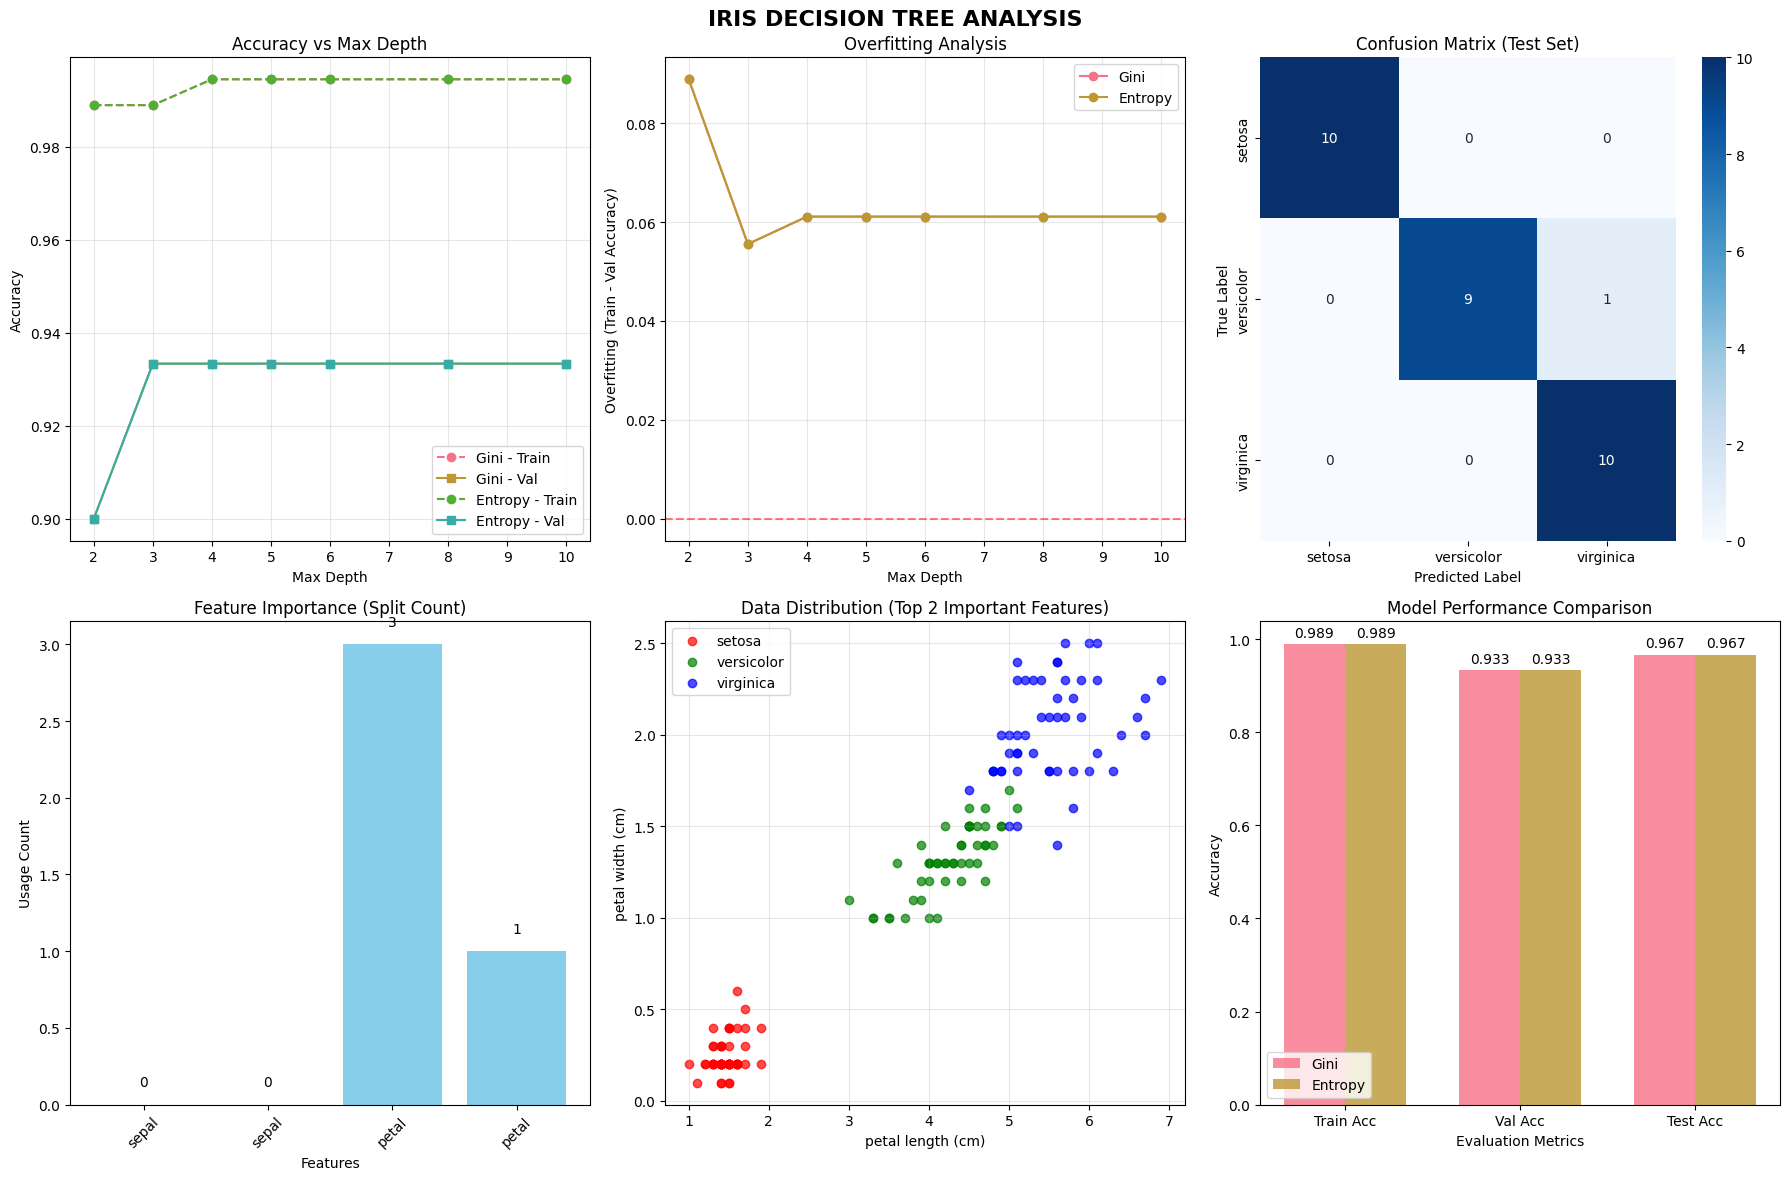

In [34]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('IRIS DECISION TREE ANALYSIS', fontsize=16, fontweight='bold')

# Plot 1: Accuracy vs Max Depth
ax1 = axes[0, 0]
for loss_func in loss_functions:
    subset = results_df[results_df['loss_function'] == loss_func]
    depth_avg = subset.groupby('max_depth')[['train_accuracy', 'val_accuracy']].mean()
    
    ax1.plot(depth_avg.index, depth_avg['train_accuracy'], 
             marker='o', label=f'{loss_func.title()} - Train', linestyle='--')
    ax1.plot(depth_avg.index, depth_avg['val_accuracy'], 
             marker='s', label=f'{loss_func.title()} - Val')

ax1.set_xlabel('Max Depth')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Max Depth')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Overfitting Analysis
ax2 = axes[0, 1]
for loss_func in loss_functions:
    subset = results_df[results_df['loss_function'] == loss_func]
    depth_avg = subset.groupby('max_depth')['overfitting'].mean()
    
    ax2.plot(depth_avg.index, depth_avg.values, 
             marker='o', label=f'{loss_func.title()}')

ax2.set_xlabel('Max Depth')
ax2.set_ylabel('Overfitting (Train - Val Accuracy)')
ax2.set_title('Overfitting Analysis')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Plot 3: Confusion Matrix
ax3 = axes[0, 2]
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=iris.target_names,
            yticklabels=iris.target_names, ax=ax3)
ax3.set_title('Confusion Matrix (Test Set)')
ax3.set_ylabel('True Label')
ax3.set_xlabel('Predicted Label')

# Plot 4: Feature Importance
ax4 = axes[1, 0]
def count_feature_usage(tree_dict, counts):
    if not tree_dict['leaf']:
        feature = tree_dict['feature']
        counts[feature] = counts.get(feature, 0) + 1
        count_feature_usage(tree_dict['left'], counts)
        count_feature_usage(tree_dict['right'], counts)

feature_counts = {}
count_feature_usage(final_model.tree, feature_counts)

features = [iris.feature_names[i] for i in range(len(iris.feature_names))]
importances = [feature_counts.get(i, 0) for i in range(len(features))]

bars = ax4.bar(range(len(features)), importances, color='skyblue')
ax4.set_xlabel('Features')
ax4.set_ylabel('Usage Count')
ax4.set_title('Feature Importance (Split Count)')
ax4.set_xticks(range(len(features)))
ax4.set_xticklabels([f.split()[0] for f in features], rotation=45)

for bar, imp in zip(bars, importances):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             str(imp), ha='center', va='bottom')

# Plot 5: Data Distribution
ax5 = axes[1, 1]
if len(feature_counts) >= 2:
    top_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)[:2]
    feat1, feat2 = top_features[0][0], top_features[1][0]
else:
    feat1, feat2 = 0, 1

colors = ['red', 'green', 'blue']
for i, species in enumerate(iris.target_names):
    mask = y == i
    ax5.scatter(X[mask, feat1], X[mask, feat2], 
               c=colors[i], label=species, alpha=0.7)

ax5.set_xlabel(iris.feature_names[feat1])
ax5.set_ylabel(iris.feature_names[feat2])
ax5.set_title('Data Distribution (Top 2 Important Features)')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Performance Summary
ax6 = axes[1, 2]
metrics = ['Train Acc', 'Val Acc', 'Test Acc']
gini_scores = []
entropy_scores = []

gini_results = results_df[results_df['loss_function'] == 'gini']
best_gini = gini_results.loc[gini_results['val_accuracy'].idxmax()]
gini_scores = [best_gini['train_accuracy'], best_gini['val_accuracy'], test_accuracy]

entropy_results = results_df[results_df['loss_function'] == 'entropy']
best_entropy_params = entropy_results.loc[entropy_results['val_accuracy'].idxmax()]

entropy_model = DecisionTree(
    split_loss_function='entropy',
    leaf_value_estimator='majority',
    max_depth=int(best_entropy_params['max_depth']),
    min_sample=int(best_entropy_params['min_sample'])
)
entropy_model.build_tree(X_train_final, y_train_final)
entropy_test_pred = entropy_model.inference_tree(X_test)
entropy_test_acc = accuracy_score(y_test, entropy_test_pred)

entropy_scores = [best_entropy_params['train_accuracy'], 
                 best_entropy_params['val_accuracy'], entropy_test_acc]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax6.bar(x - width/2, gini_scores, width, label='Gini', alpha=0.8)
bars2 = ax6.bar(x + width/2, entropy_scores, width, label='Entropy', alpha=0.8)

ax6.set_xlabel('Evaluation Metrics')
ax6.set_ylabel('Accuracy')
ax6.set_title('Model Performance Comparison')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics)
ax6.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()